# Accumulation to rate examples

In [1]:
from earthkit import transforms as ekt
from earthkit import data as ekd

from earthkit.data.testing import earthkit_remote_test_data_file

The examples demonstrated here use sample data that was extracted from the CDS for testing purposes.

We provide several examples which attempt to cover the range of accumulation types that you may come accross when working with ECMWF data. Please refer to the [ECMWF documentation](https://confluence.ecmwf.int/x/hrTICw) for a detailed summary of the accumulation types.

## Accumulated from start of step (e.g. ERA5)

ERA5 accumulates data from the start of each time step, therefore to convert to a rate we need to divide by the length of the time step.

In this example we use some sample total precipitation data from the [ERA5 single levels dataset](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels). It is hourly data for January 2024 over Europe at 3˚ⅹ3˚spatial resolution.

As this is reanalysis data, we open the data using `time_dim_mode="valid_time"` which provides a more intuitive representation of data which can be described with a single time dimension. If required. the accumulation_to_rate function can handle start of step accumulated data if it is opened using the default `time_dim_mode="forecast"`.

In [2]:
# Open the demonstration ERA5 single levels data with earthkit data
remote_era5_file = earthkit_remote_test_data_file("era5-sfc-precip-3deg-202401.grib")
era5_data = ekd.from_source("url", remote_era5_file)

# Open the data with xarray using the valid_time time dimension mode.
ds_era5 = era5_data.to_xarray(time_dim_mode="valid_time")
ds_era5

<xarray.Dataset> Size: 3MB
Dimensions:     (valid_time: 744, latitude: 19, longitude: 29)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:...
  * latitude    (latitude) float64 152B 79.0 76.0 73.0 70.0 ... 31.0 28.0 25.0
  * longitude   (longitude) float64 232B -25.0 -22.0 -19.0 ... 53.0 56.0 59.0
Data variables:
    tp          (valid_time, latitude, longitude) float64 3MB ...
Attributes: (12/13)
    param:        tp
    paramId:      228
    class:        ea
    stream:       oper
    levtype:      sfc
    type:         fc
    ...           ...
    date:         20231231
    time:         1800
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

The ERA5 single levels data is accumulated from the start of each time step, therefore for the accumulation_to_rate conversion, we set `accumulation_type="start_of_step"`. This is the default value, we include here only for demonstration purposes.

The accumulation_to_rate function assumes that the data contains consecutive time steps and calculates the step length as the difference between time steps. If this is not the case, then you can provide the `step` as keyword argument.

In [3]:
ds_era5_rate = ekt.temporal.accumulation_to_rate(ds_era5, accumulation_type="start_of_step")
ds_era5_rate

<xarray.Dataset> Size: 3MB
Dimensions:     (valid_time: 744, latitude: 19, longitude: 29)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:...
  * latitude    (latitude) float64 152B 79.0 76.0 73.0 70.0 ... 31.0 28.0 25.0
  * longitude   (longitude) float64 232B -25.0 -22.0 -19.0 ... 53.0 56.0 59.0
Data variables:
    tp          (valid_time, latitude, longitude) float64 3MB 0.0 0.0 ... 0.0

By inspecting the attributes of the `tp` data variable above you can see that the units and long_name have been updated to describe the rate variable.

Additionally, a history attribute has been added describing the that data has been converted from an accumulation to a rate. This can be surpressed by setting `provenance=False` in the function call.

All other variable and dataset attributes have been removed, this is intentional as it cannot be guarenteed that they are still valid for the rate data.

To see the effect of the accumulation to rate conversion, we plot the data on the same axis. We plot the accumulated data as a bar chart (blue) and the rate data as line (orange). As the data is accumulated since the start of step, this change is essentially just a change in units, which is evident by the identical shapes of the bars and line (with a small offset due to the plotting axis range).

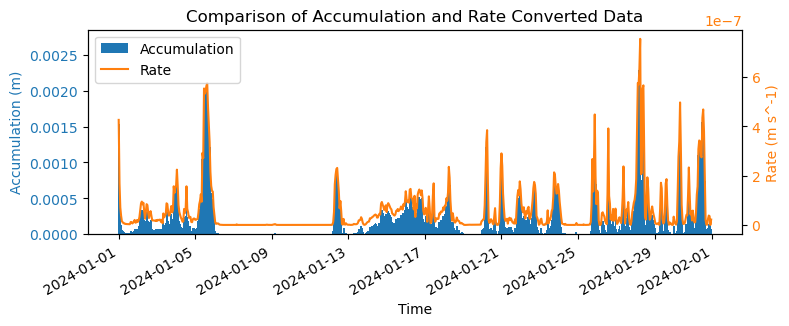

In [4]:
# Plot the raw accumulation and the rate converted data for comparison.
import matplotlib.pyplot as plt
plot_point = {'latitude': 5, 'longitude': 5}
fig, ax1 = plt.subplots(figsize=(8, 3))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(f'Accumulation ({ds_era5["tp"].units})', color=color)
ax1.bar(
    ds_era5['valid_time'], ds_era5['tp'].isel(plot_point),
    color=color, label='Accumulation', width=0.1, lw=0
)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel(f'Rate ({ds_era5_rate["tp"].units})', color=color)  # we already handled the
ax2.plot(
    ds_era5_rate['valid_time'], ds_era5_rate['tp'].isel(plot_point),
    color=color, label='Rate',  # ls='dotted',
)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparison of Accumulation and Rate Converted Data')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate()

# Plot legend with handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.show()


## Daily accumulation (e.g. ERA5-Land)

The ERA5-land is accumulated from the start of each day, which makes it a particularly tricky example as we must intricately deaccumulate the data then convert to a rate. Luckily, all this is simplified using the accumulation_to_rate function.

In this example we use some sample total precipitation data from the
[ERA5-land dataset](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land).
It is hourly data for January 2024 over Europe at 3˚ⅹ3˚spatial resolution.

As this is reanalysis data, we open the data using `time_dim_mode="valid_time"` which provides a more intuitive representation of data which can be described with a single time dimension. If required. the accumulation_to_rate function can handle daily accumulated data if it is opened using the default `time_dim_mode="forecast"`.

In [5]:
# Open the demonstration ERA5-land data with earthkit data
remote_era5land_file = earthkit_remote_test_data_file("era5-land-precip-3deg-202401.grib")
era5land_data = ekd.from_source("url", remote_era5land_file)

# Open the data with xarray using the valid_time time dimension mode.
ds_era5land = era5land_data.to_xarray(time_dim_mode="valid_time")
ds_era5land

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 744, latitude: 19, longitude: 34)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:...
  * latitude    (latitude) float64 152B 79.0 76.0 73.0 70.0 ... 31.0 28.0 25.0
  * longitude   (longitude) float64 272B -20.0 -17.0 -14.0 ... 73.0 76.0 79.0
Data variables:
    tp          (valid_time, latitude, longitude) float64 4MB ...
Attributes: (12/13)
    param:        tp
    paramId:      228
    class:        l5
    stream:       oper
    levtype:      sfc
    type:         fc
    ...           ...
    date:         20231231
    time:         0
    domain:       g
    number:       0
    Conventions:  CF-1.8
    institution:  ECMWF

The ERA5-land is accumulated from the start of each day, therefore we set `accumulation_type="start_of_day"`.

The accumulation_to_rate function assumes that the data contains consecutive time steps and calculates the step length as the difference along the detected time dimension.


In [6]:
ds_era5land_rate = ekt.temporal.accumulation_to_rate(ds_era5land, accumulation_type="start_of_day")
ds_era5land_rate

<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 744, latitude: 19, longitude: 34)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2024-01-01 ... 2024-01-31T23:...
  * latitude    (latitude) float64 152B 79.0 76.0 73.0 70.0 ... 31.0 28.0 25.0
  * longitude   (longitude) float64 272B -20.0 -17.0 -14.0 ... 73.0 76.0 79.0
Data variables:
    tp          (valid_time, latitude, longitude) float64 4MB nan nan ... 0.0

As with the previous example, the units and long_name attributes of the `tp` data variable have been updated to describe the rate variable, and a history attribute added.

Below we plot the accumulation and rate data on the same axis using the same styling as the previous example. This time the effect of the accumulation to rate is more evident as there is both a deaccumulation and a unit conversion applied. Dashed vertical lines at the start of each day have been included to demonstrate the restart of the accumulated precipitation.


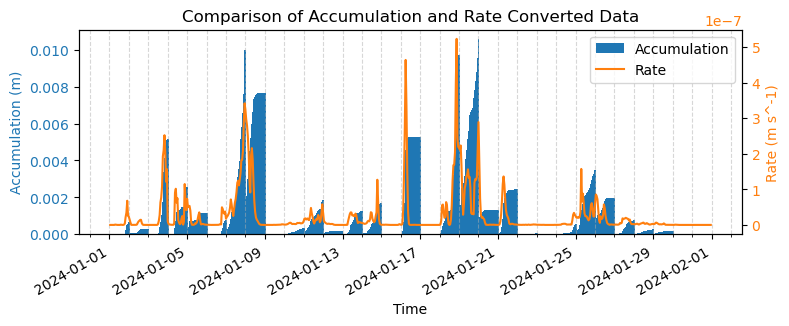

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Plot the raw accumulation and the rate converted data for comparison.
plot_point = {'latitude': 10, 'longitude': 18}
fig, ax1 = plt.subplots(figsize=(8, 3))
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel(f'Accumulation ({ds_era5land["tp"].units})', color=color)
ax1.bar(
    ds_era5land['valid_time'], ds_era5land['tp'].isel(plot_point),
    color=color, label='Accumulation', width=0.1, lw=0
)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel(f'Rate ({ds_era5land_rate["tp"].units})', color=color)  # we already handled the
ax2.plot(
    ds_era5land_rate['valid_time'], ds_era5land_rate['tp'].isel(plot_point),
    color=color, label='Rate',  # ls='dotted',
)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparison of Accumulation and Rate Converted Data')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate()

# Add minor ticks for each day
ax1.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
# Gridlines on major and minor ticks (daily)
ax1.xaxis.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot legend with handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2)
plt.show()


## Accumulated from start of forecast (e.g. Seasonal forecasts)

Seasonal forecast data is accumulated from the start of each forecast initialisation, therefore we need to deaccumulate the data and then convert to a rate. It is common place for forecast data to include multiple forecast initialisations in a single file, therefore in the example below we will use the `time_dim_mode="forecast"` representation of the data.

In this example we use some sample total precipitation data from the
[Seasonal forecast daily and subdaily dataset](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels).
It provides 60 days of daily data for two forecasts, initialised January 1st and February 1st 2024, over Europe at 3˚ⅹ3˚spatial resolution.

In [8]:
# Open the demonstration Seasonal forecast data with earthkit data
remote_seas5_file = earthkit_remote_test_data_file("seas5-precip-3deg-202401-202402.grib")
seas5_data = ekd.from_source("url", remote_seas5_file)

# Open the data with xarray using the valid_time time dimension mode.
ds_seas5 = seas5_data.to_xarray(time_dim_mode="forecast", add_valid_time_coord=True)
ds_seas5

<xarray.Dataset> Size: 32MB
Dimensions:                  (number: 51, forecast_reference_time: 2, step: 60,
                              latitude: 19, longitude: 34)
Coordinates:
  * number                   (number) int64 408B 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 16B 202...
  * step                     (step) timedelta64[ns] 480B 1 days ... 60 days
  * latitude                 (latitude) float64 152B 79.0 76.0 ... 28.0 25.0
  * longitude                (longitude) float64 272B -20.0 -17.0 ... 76.0 79.0
    valid_time               (forecast_reference_time, step) datetime64[ns] 960B ...
Data variables:
    tp                       (number, forecast_reference_time, step, latitude, longitude) float64 32MB ...
Attributes: (12/14)
    param:        tp
    paramId:      228
    class:        c3
    stream:       mmsf
    levtype:      sfc
    type:         fc
    ...           ...
    time:         0
    origin:       ecmf
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF

We can now caculate the rate by setting the accumulation type to "start_of_forecast".

In [9]:
ds_seas5_rate = ekt.temporal.accumulation_to_rate(
    ds_seas5, accumulation_type="start_of_forecast",
)
ds_seas5_rate

<xarray.Dataset> Size: 32MB
Dimensions:                  (number: 51, forecast_reference_time: 2, step: 60,
                              latitude: 19, longitude: 34)
Coordinates:
  * number                   (number) int64 408B 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 16B 202...
  * step                     (step) timedelta64[ns] 480B 1 days ... 60 days
  * latitude                 (latitude) float64 152B 79.0 76.0 ... 28.0 25.0
  * longitude                (longitude) float64 272B -20.0 -17.0 ... 76.0 79.0
    valid_time               (forecast_reference_time, step) datetime64[ns] 960B ...
Data variables:
    tp                       (step, number, forecast_reference_time, latitude, longitude) float64 32MB ...

Below is a plot of the accumulated vs rate data for the two forecast initialisations in the file, January and February 2024.

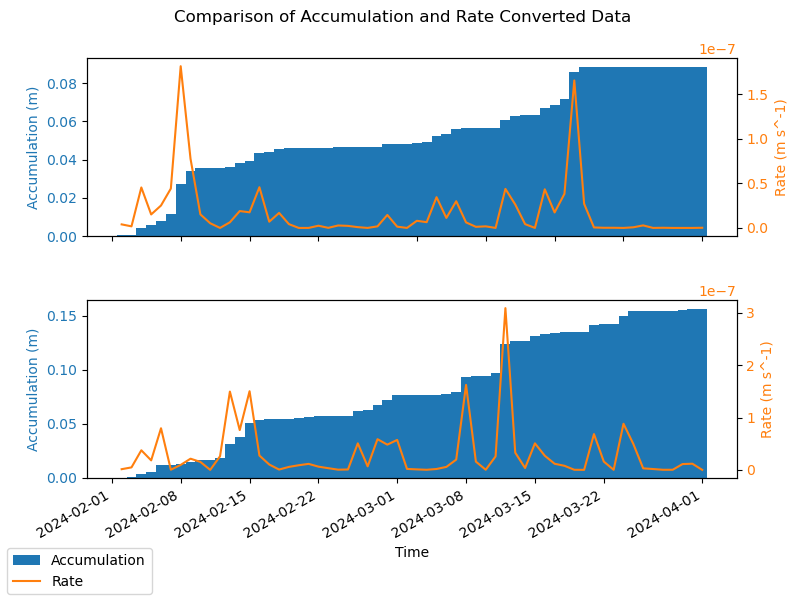

In [10]:
import matplotlib.pyplot as plt

n_forecasts = len(ds_seas5.forecast_reference_time)

# Plot the raw accumulation and the rate converted data for comparison.
plot_point = {'latitude': 10, 'longitude': 18, "number": 0}
fig, axes = plt.subplots(figsize=(8, 3*n_forecasts), nrows=n_forecasts)

for i in range(n_forecasts):
    ax1 = axes[i]
    _ds_accum = ds_seas5.isel(**plot_point, forecast_reference_time=i)
    _ds_rate = ds_seas5_rate.isel(**plot_point, forecast_reference_time=i)
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'Accumulation ({_ds_accum["tp"].units})', color=color)
    ax1.bar(
        _ds_accum['valid_time'], _ds_accum['tp'],
        color=color, label='Accumulation', width=1.0,
    )
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel(f'Rate ({_ds_rate["tp"].units})', color=color)  # we already handled the
    ax2.plot(
        _ds_rate['valid_time'], _ds_rate['tp'],
        color=color, label='Rate',  # ls='dotted',
    )
    ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Comparison of Accumulation and Rate Converted Data')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate()

# Plot legend with handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='lower left')

plt.show()


## Deaccumulate only

Deaccumulation of data is akin to converting to a rate where the units of the rate are equivalent to the length of the time step. This can be done using the `earthkit.transforms.temporal.deaccumulate` function, as demonstrated below.

ℹ️ **Note:** The deaccumulation function is a wrapper of the accumulation_to_rate function with `rate_units="step_length"`.

The example below uses the same seasonal forecast data as the previous example, and deaccumulates the total precipitation such that is represents the accumulation of a single time-step. Comparable with the native ERA5 data in the first example.

In [11]:
ds_seas5_deaccumulate = ekt.temporal.deaccumulate(
    ds_seas5, accumulation_type="start_of_forecast",
)
ds_seas5_deaccumulate

<xarray.Dataset> Size: 32MB
Dimensions:                  (number: 51, forecast_reference_time: 2, step: 60,
                              latitude: 19, longitude: 34)
Coordinates:
  * number                   (number) int64 408B 0 1 2 3 4 5 ... 46 47 48 49 50
  * forecast_reference_time  (forecast_reference_time) datetime64[ns] 16B 202...
  * step                     (step) timedelta64[ns] 480B 1 days ... 60 days
  * latitude                 (latitude) float64 152B 79.0 76.0 ... 28.0 25.0
  * longitude                (longitude) float64 272B -20.0 -17.0 ... 76.0 79.0
    valid_time               (forecast_reference_time, step) datetime64[ns] 960B ...
Data variables:
    tp                       (step, number, forecast_reference_time, latitude, longitude) float64 32MB ...

Below is a plot of the accumulated and de-accumulated data for the two forecast initialisations in the file, January and February 2024. 
The plot demonstrates that the deaccumulation is the same as the rate calculated with the previous example but with differing units.

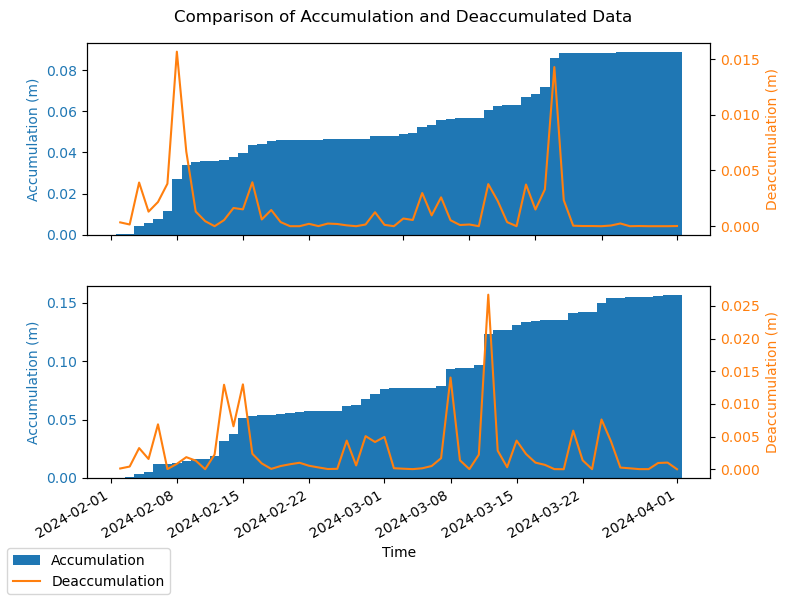

In [12]:
import matplotlib.pyplot as plt

n_forecasts = len(ds_seas5.forecast_reference_time)

# Plot the raw accumulation and the rate converted data for comparison.
plot_point = {'latitude': 10, 'longitude': 18, "number": 0}
fig, axes = plt.subplots(figsize=(8, 3*n_forecasts), nrows=n_forecasts)

for i in range(n_forecasts):
    ax1 = axes[i]
    _ds_accum = ds_seas5.isel(**plot_point, forecast_reference_time=i)
    _ds_deaccum = ds_seas5_deaccumulate.isel(**plot_point, forecast_reference_time=i)
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'Accumulation ({_ds_accum["tp"].units})', color=color)
    ax1.bar(
        _ds_accum['valid_time'], _ds_accum['tp'],
        color=color, label='Accumulation', width=1.0,
    )
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:orange'
    ax2.set_ylabel(f'Deaccumulation ({_ds_deaccum["tp"].units})', color=color)  # we already handled the
    ax2.plot(
        _ds_deaccum['valid_time'], _ds_deaccum['tp'],
        color=color, label='Deaccumulation',  # ls='dotted',
    )
    ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Comparison of Accumulation and Deaccumulated Data')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.autofmt_xdate()

# Plot legend with handles from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc='lower left')

plt.show()
